In [16]:
import pandas as pd
df=pd.read_csv('Preprocessed.csv')
df.head(3)

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,year,month,day
0,-17.0503,-74.0580,30.94,4.6,1,12,183.0,4.973,0.83,3,7640,48327,1180,0,15.2,10.5,0.146,14,1,15,23,2020,12,31
1,-39.3139,-72.0545,107.55,4.8,11,12,52.0,0.389,1.10,3,7638,48324,30040,0,4.0,3.9,0.093,11,1,15,23,2020,12,29
2,-34.3785,-70.8291,92.47,4.6,10,12,44.0,0.211,0.96,3,7637,48323,16958,0,3.5,3.8,0.143,8,1,15,6,2020,12,29


In [17]:
df.shape

(57206, 24)

In [18]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')
X = df.drop("mag", axis=1)
y = df["mag"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [19]:
sc = RobustScaler()

X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [20]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

def create_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(15, input_shape=input_shape)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Incremental Training for BiLSTM Model
def train_incremental_bilstm_model(base_model, X_train_new, y_train_new, epochs=15, batch_size=28):
    base_model.fit(X_train_new, y_train_new, epochs=epochs, batch_size=batch_size, verbose=1)
    return base_model

def evaluate_bilstm_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mse)
    return mse, r2, rmse

# Train Incremental BiLSTM Model
incremental_bilstm_model = create_bilstm_model(input_shape=(X_train_array.shape[1], 1))
incremental_bilstm_model = train_incremental_bilstm_model(incremental_bilstm_model, X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1), y_train)



Epoch 1/15
1635/1635 [==============================] - 26s 13ms/step - loss: 0.7023
Epoch 2/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.2516
Epoch 3/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.2235
Epoch 4/15
1635/1635 [==============================] - 20s 13ms/step - loss: 0.2102
Epoch 5/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.1997
Epoch 6/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.1873
Epoch 7/15
1635/1635 [==============================] - 21s 13ms/step - loss: 0.1765
Epoch 8/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.1687
Epoch 9/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.1603
Epoch 10/15
1635/1635 [==============================] - 20s 12ms/step - loss: 0.1550
Epoch 11/15
1635/1635 [==============================] - 22s 13ms/step - loss: 0.1505
Epoch 12/15
1635/1635 [==============================] - 22s 13

In [21]:
# Evaluate Incremental BiLSTM Model
incremental_bilstm_mse, incremental_bilstm_r2, incremental_bilstm_rmse = evaluate_bilstm_model(incremental_bilstm_model, X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1), y_test)
print("Incremental BiLSTM Model Mean Squared Error: ", incremental_bilstm_mse)
print("Incremental BiLSTM Model R2 Score: ", incremental_bilstm_r2)

358/358 [==============================] - 2s 4ms/step
Incremental BiLSTM Model Mean Squared Error:  0.1282837542007141
Incremental BiLSTM Model R2 Score:  0.759638123478351


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming `y_test_pred` is the predicted values from your BiLSTM model
y_test_pred = incremental_bilstm_model.predict(X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1))

# Calculate MSE
mse = mean_squared_error(y_test, y_test_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred)

# Calculate R2 Score
r2 = r2_score(y_test, y_test_pred)

# Print all metrics
print("Incremental BiLSTM Model Mean Squared Error (MSE):", mse)
print("Incremental BiLSTM Model Root Mean Squared Error (RMSE):", rmse)
print("Incremental BiLSTM Model Mean Absolute Error (MAE):", mae)
print("Incremental BiLSTM Model R2 Score:", r2)


358/358 [==============================] - 1s 4ms/step
Incremental BiLSTM Model Mean Squared Error (MSE): 0.1282837542007141
Incremental BiLSTM Model Root Mean Squared Error (RMSE): 0.3581672154186004
Incremental BiLSTM Model Mean Absolute Error (MAE): 0.2719953149416463
Incremental BiLSTM Model R2 Score: 0.759638123478351


In [23]:
import pandas as pd

# Assuming y_test contains the actual values and y_test_pred contains the predicted values

# Create a DataFrame with actual and predicted values
df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_test_pred.flatten()})

# Save the DataFrame to an Excel file
df.to_excel('bilstm_actual_vs_predicted.xlsx', index=False)

print("Data saved to actual_vs_predicted.xlsx")


Data saved to actual_vs_predicted.xlsx


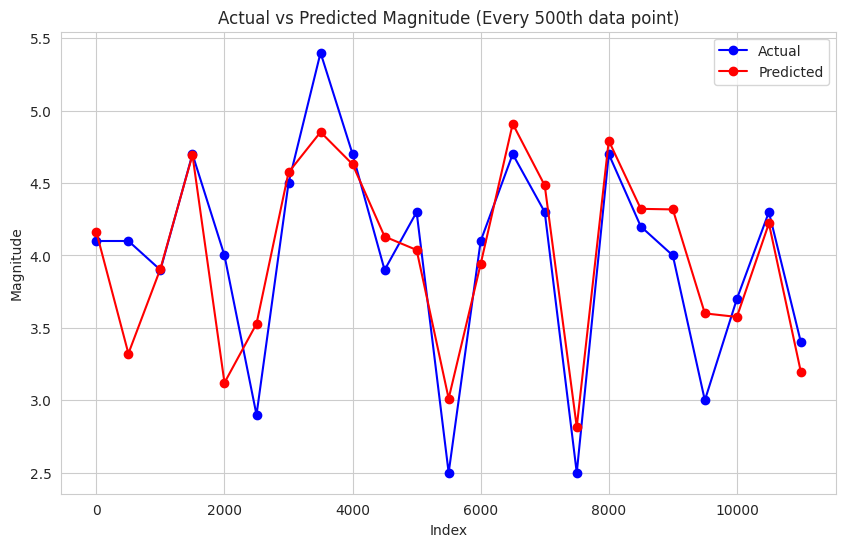

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel file
predictions = pd.read_excel('bilstm_actual_vs_predicted.xlsx')

# Plotting every nth data point
n = 500 # Change this value as needed
plt.figure(figsize=(10, 6))
plt.plot(predictions.index[::n], predictions['Actual'][::n], marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(predictions.index[::n], predictions['Predicted'][::n], marker='o', linestyle='-', color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.title('Actual vs Predicted Magnitude (Every {}th data point)'.format(n))
plt.legend()
plt.grid(True)
plt.show()
